# Lab 4: Effect of **data augmentation** on a *shallow, linear FCN*

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2023_Lab_04_FCN_Augmentation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#### High-level overview

In the *Lab* that follows, we will explore the effect of **data augmentation** on the structure of learned weights in a *neural network* model. As an example, we will consider a *shallow, linear FCN* (fully-connected network with just 1 layer and no non-linearities) that is trained on the MNIST *classification task*.

On a high level, you need to:
- Define and train a *shallow, linear FCN* on the MNIST dataset, using *training-set augmentation* by means of *random rotations*;
- Extract the learned weights from the trained model;
- Visualize the learned weights as *images* and comment on their structure.

The rest of the notebook will guide you through more detailed steps you need to follow.

#### Loading the datasets and defining augmentation strategies

Load the (training and test) *MNIST* datasets as we did in the previous lab, with the following meaningful differences:
- Apply random rotations to the dataset used for training, using a rotation range of $[0, 180]$ degrees.
- Apply normalization to both datasets, using a mean of $0.1307$ and a standard deviation of $0.3081$ (they are notable, pre-computed values for the MNIST **training** dataset);

**Hint**: look up the documentation for the `transforms.RandomRotation` and `transforms.Normalize` classes.

**Optional**: Visualize the augmented training dataset, to get a sense of the effect of the augmentation strategy.

In [2]:
from tqdm import trange

import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Defining transforms
augmentation = transforms.RandomAffine(degrees=(0, 180), translate=None, scale=None)
to_tensor = transforms.ToTensor()
normalization = transforms.Normalize(mean=0.1307, std=0.3081)

# Loading the datasets
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([augmentation, to_tensor, normalization]),
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([augmentation, to_tensor, normalization]),
    download=True,
)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[0.0, 180.0])
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


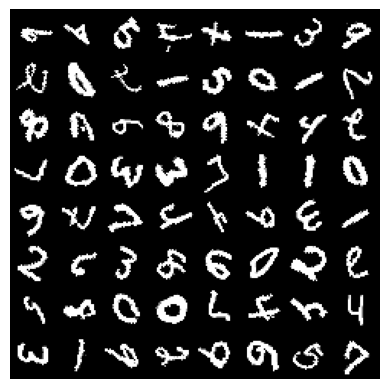

In [44]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

#### Model definition and training

Define the model and train it on the classification task, as we did in the previous *Lab*. Use fixed-learning-rate *Stochastic Gradient Descent* (with no momentum) as the optimizer. Feel free to experiment with the other hyperparameters.

**Optional**: Plot the training loss as the training progresses. Show also test loss at the beginning and at the end of training.


In [45]:
# Model definition
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)  # More numerically stable than softmax
        return x

In [46]:
model = MyModel()
out = model(images)
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([64, 10])  i.e.: batch_size x num_classes


In [47]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

In [48]:
model = (
    MyModel()
)  # Re-instantiate the model to reset the weights/gradients. Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model = model.to(device) 

In [49]:
num_epochs = 5  # Number of times the whole (training) dataset is used for training
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [50]:
train_loss = []
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model1 = (
        model.train()
    )  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model1(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

 20%|██        | 1/5 [00:11<00:47, 11.82s/it]

Epoch: 1 | Loss: 1.058501783977069 | Train Accuracy: 65.81176627534686


 40%|████      | 2/5 [00:23<00:35, 11.92s/it]

Epoch: 2 | Loss: 0.9755612909475793 | Train Accuracy: 68.8934098185699


 60%|██████    | 3/5 [00:35<00:23, 11.97s/it]

Epoch: 3 | Loss: 0.96585023842092 | Train Accuracy: 69.47371931696905


 80%|████████  | 4/5 [00:47<00:11, 11.75s/it]

Epoch: 4 | Loss: 0.9580266589543354 | Train Accuracy: 69.7288553895411


100%|██████████| 5/5 [00:59<00:00, 11.86s/it]

Epoch: 5 | Loss: 0.9586935902417915 | Train Accuracy: 69.68216382070437


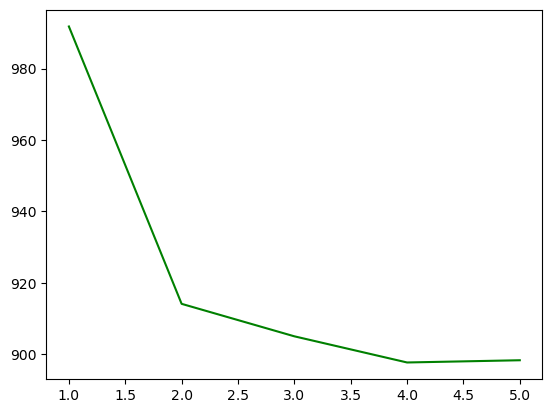

In [51]:
train_loss = np.asarray(train_loss)
plt.plot(np.arange(1, num_epochs + 1),train_loss, 'g')

In [52]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    logits = model1(images)
    test_acc += get_batch_accuracy(logits, labels)
print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 70.703125


#### Weights extraction and visualization

Extract the tensors corresponding to learned weights from the trained model (they are stored as the `weights` attribute of the linear layer), and visualize them as images.

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.

**Remark**: in order to be able to visualize the weights as images, they need to be appropriately scaled (as tensor) within the $[0,1]$ range.


In [54]:
rescaled_weight = (model1.fc.weight.max()-model1.fc.weight)/(model1.fc.weight.max()-model1.fc.weight.min())

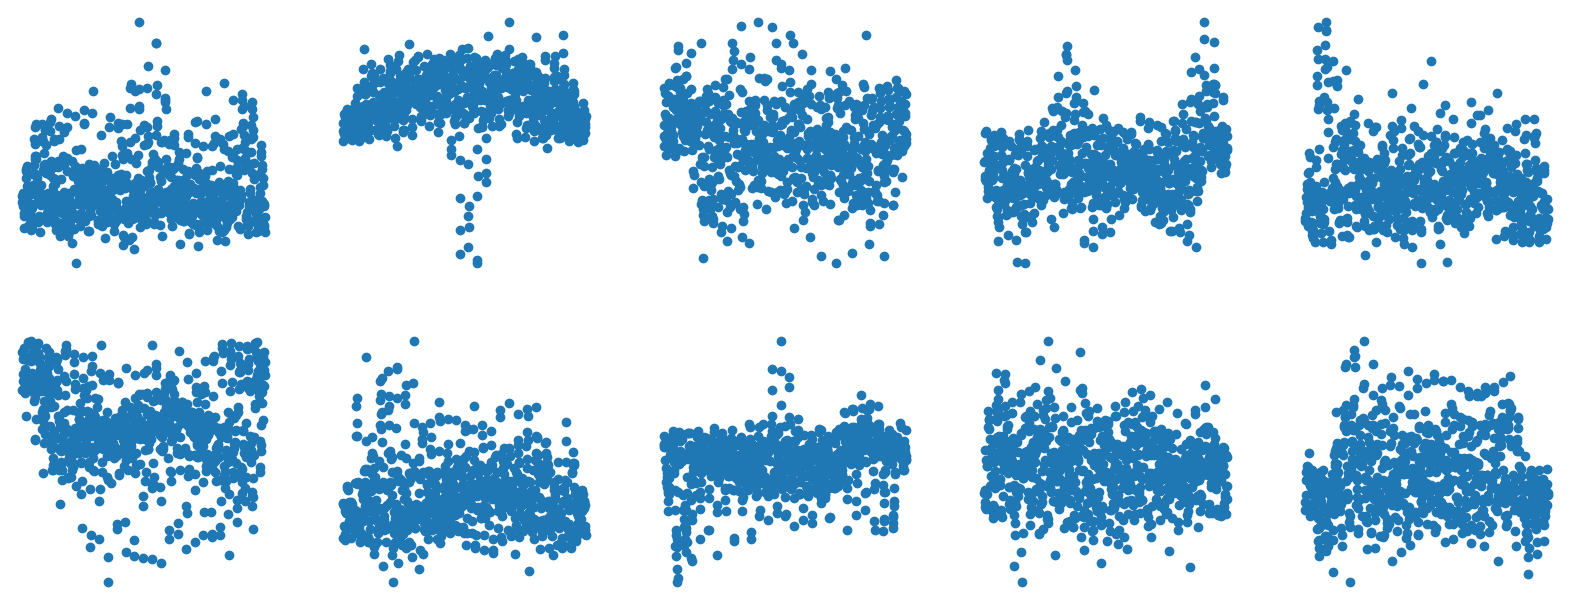

In [64]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.scatter(np.arange(0,1+1/784,1/783),rescaled_weight[i,:].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

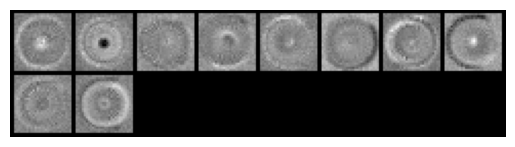

In [66]:
# Plot
rescaled_weight = rescaled_weight.reshape(rescaled_weight.shape[0], -1, 28, 28)
imshow(torchvision.utils.make_grid(rescaled_weight.detach().cpu()))

#### Optional I: Training with different augmentation strategies

Repeat the same process described above, but using different augmentation strategy, namely:
- Apply a central (vertical or horizontal, one only or both) flip to images in the training dataset;
- Apply random traslations to images in the training dataset, bound by an arbitrary maximum;

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.


In [72]:
augmentation = transforms.RandomHorizontalFlip()
augmentation1 = transforms.RandomVerticalFlip()
to_tensor = transforms.ToTensor()
normalization = transforms.Normalize(mean=0.1307, std=0.3081)
# Loading the datasets
train_dataset_vh = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([augmentation,augmentation1, to_tensor, normalization]),
    download=True,
)
test_dataset_vh = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([augmentation,augmentation1, to_tensor, normalization]),
    download=True,
)

train_loader_vh = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader_vh= DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


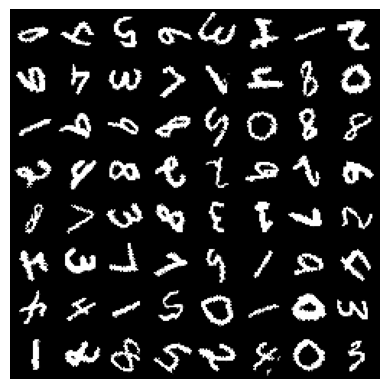

In [73]:
# get some random training images
dataiter = train_loader_vh.__iter__()
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

In [74]:
model1 = (
    MyModel()
)  # Re-instantiate the model to reset the weights/gradients. Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model1 = model1.to(device) 

In [75]:
train_loss = []
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model1 = (
        model1.train()
    )  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model1(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model1.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

 20%|██        | 1/5 [00:12<00:48, 12.22s/it]

Epoch: 1 | Loss: 2.4936951629125703 | Train Accuracy: 8.596251334044824


 40%|████      | 2/5 [00:24<00:37, 12.38s/it]

Epoch: 2 | Loss: 2.495968776934938 | Train Accuracy: 8.706310032017075


 60%|██████    | 3/5 [00:37<00:25, 12.50s/it]

Epoch: 3 | Loss: 2.4945003177211276 | Train Accuracy: 8.694637139807897


 80%|████████  | 4/5 [00:50<00:12, 12.66s/it]

Epoch: 4 | Loss: 2.490469920597056 | Train Accuracy: 8.666288687299893


100%|██████████| 5/5 [01:04<00:00, 12.94s/it]

Epoch: 5 | Loss: 2.4951884258009707 | Train Accuracy: 8.544557097118464


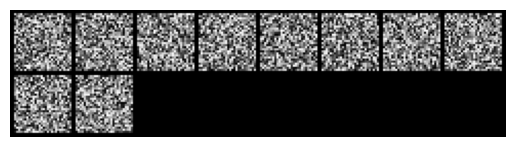

: 

In [76]:
rescaled_weight = (model1.fc.weight.max()-model1.fc.weight)/(model1.fc.weight.max()-model1.fc.weight.min())
# Plot
rescaled_weight = rescaled_weight.reshape(rescaled_weight.shape[0], -1, 28, 28)
imshow(torchvision.utils.make_grid(rescaled_weight.detach().cpu()))

#### Optional II: Testing for the invariance of the learned representation

Test that the internal representation produced by the weights learned under data augmentation is indeed invariant to the same transformation used for data augmentation. You may follow the guidance given in [this notebook](AdvML_UniTS_2023_Lab_04bis_FCN_Invariance.ipynb).
